 # MVPA Factors


In [24]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [30]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_02_factors')

# brain masks
mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c_res-2_dilated.nii')
mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c_res-2_dilated.nii')
mask_stab_file  = os.path.join(root_dir, 'derivatives', 'mvpa_03_full_temp', 'STAB_mask.nii.gz')

In [26]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_factors_dataset.nii.gz') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_factors_trial_types.txt') & f.startswith('sub-')]
label_files.sort()

In [27]:
# concatenate all datasets
D = nb.concat_images(dataset_files, axis=3)

In [28]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove the 2 digit number in the end
labels = np.array([l[:-2] for l in labels])

In [31]:
# Load mask 
masker = NiftiMasker(mask_img=mask_brain_file, standardize=False, detrend=False)
#masker = NiftiMasker(mask_img=mask_gm_file, standardize=False, detrend=False)
#masker = NiftiMasker(mask_img=mask_stab_file, standardize=False, detrend=False)
samples = masker.fit_transform(D)

In [32]:
# generate an array of chunk labels
# 13 subjects, 9 x 2 music for each of the 4 runs
chunks = np.repeat(np.arange(1,14), 9*2*4)

In [33]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')

## Manual Leave One Subject Out Cross Validation

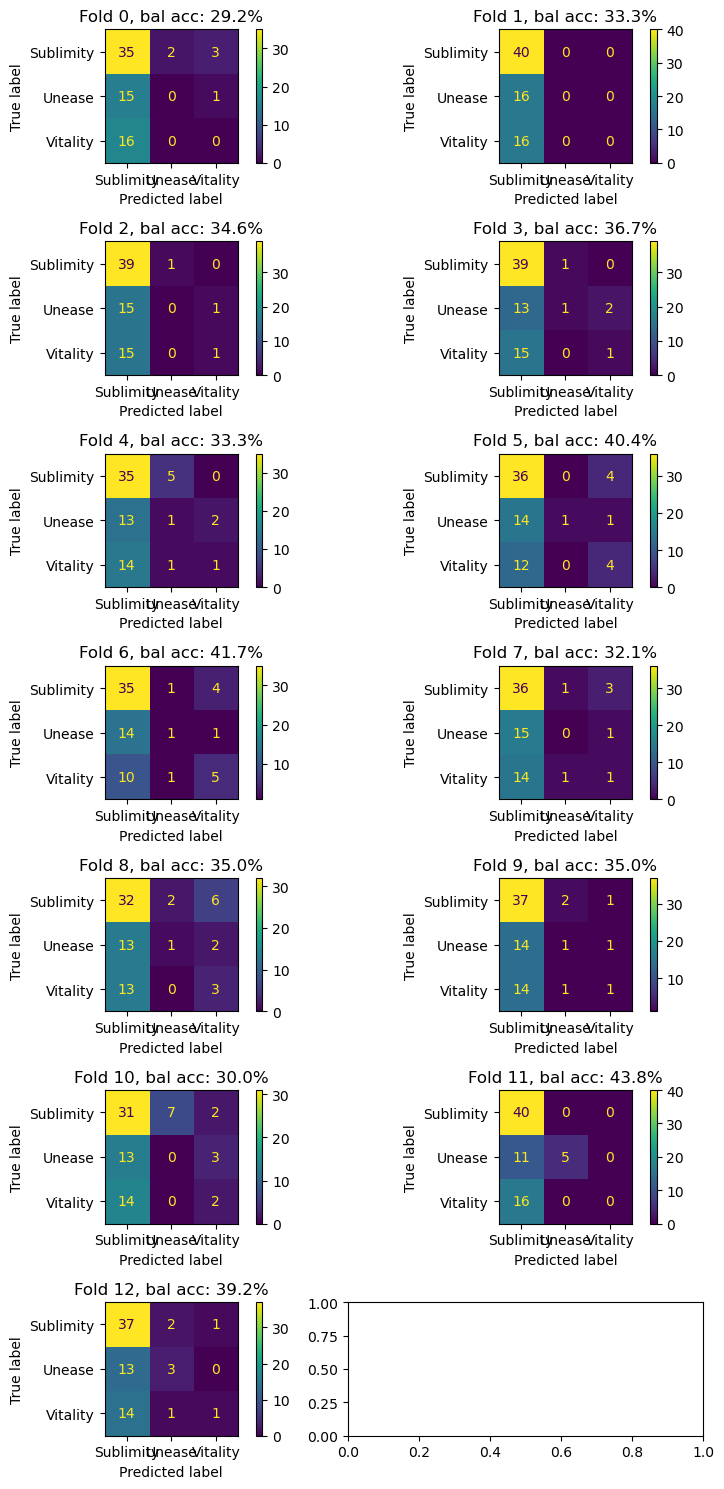

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = 13
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

fig, ax = plt.subplots(7, 2, figsize=(8, 15))

for ff in range(n_folds):
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask]
    y_train = labels[train_mask]
    X_test = samples[test_mask]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()


In [35]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 54.1% ± 4.3%
Mean balanced accuracy: 35.7% ± 4.3%
